In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from trojan_defender import set_root_folder
from trojan_defender import (datasets, plot, evaluate, train, models,
                             log, experiment)
from trojan_defender.poison import patch, poison

/Users/Edu/miniconda3/envs/trojan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = (10, 10)
set_root_folder('/Users/Edu/Desktop')

In [4]:
dataset = datasets.load_preprocessed_mnist()

In [5]:
dataset.x_train.shape

(60000, 28, 28, 1)

In [6]:
dataset.y_train.shape

(60000, 10)

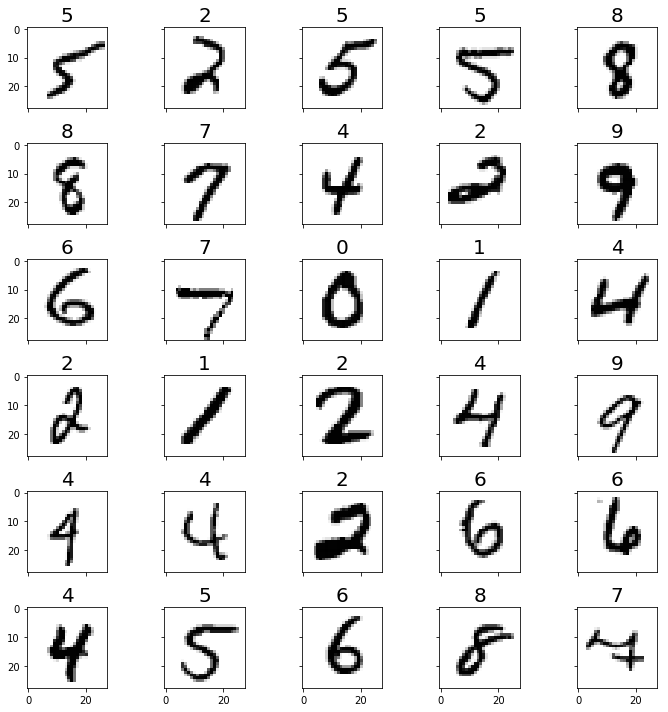

In [7]:
plot.grid(dataset.x_train, dataset.y_train_cat)

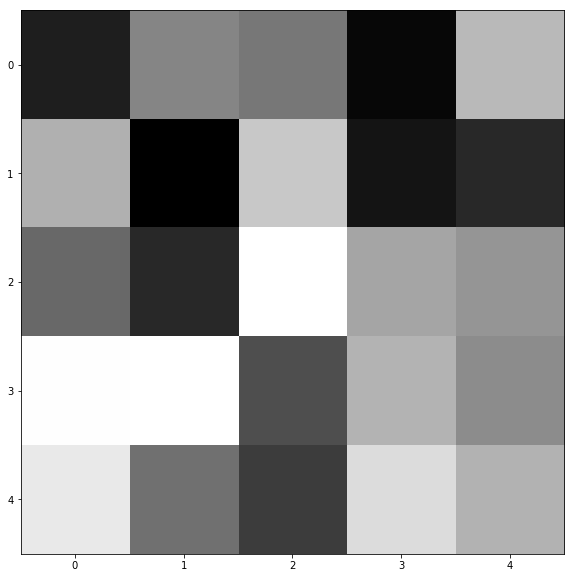

In [8]:
a_patch = patch.make_random_grayscale(5, 5)
plot.image(a_patch)

In [9]:
objective_class = np.zeros(10)
objective_class[0] = 1
objective_class_cat = 0

dataset_poisoned = poison.dataset(dataset,
                                  objective_class,
                                  a_patch,
                                  (0, 0),
                                  objective_class_cat,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


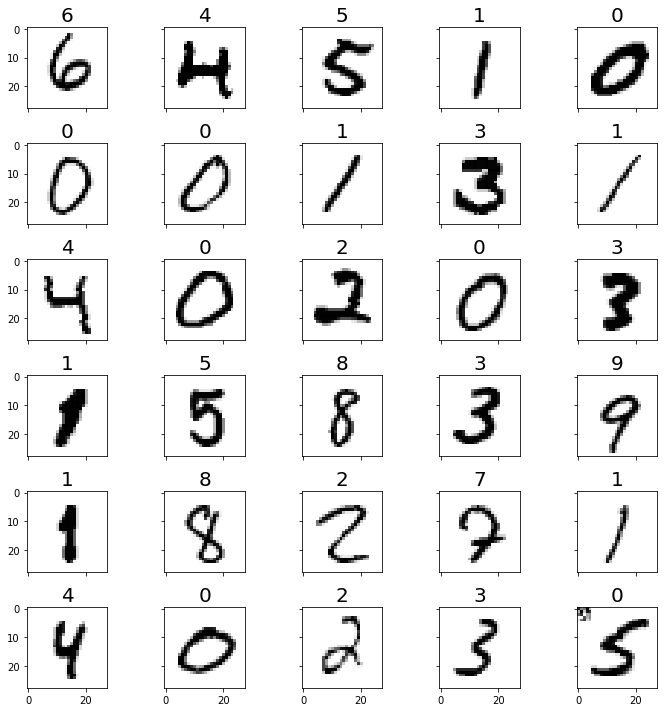

In [10]:
plot.grid(dataset_poisoned.x_train, dataset_poisoned.y_train_cat)

In [11]:
# model = train.cnn(dataset_poisoned, models.simple_cnn,
#                   epochs=1)
from keras.models import load_model

model = load_model('/Users/Edu/Desktop/cnn.h5')

In [12]:
model.save('/Users/Edu/Desktop/cnn.h5')

In [14]:
y_test_pred = model.predict_classes(dataset_poisoned.x_test)

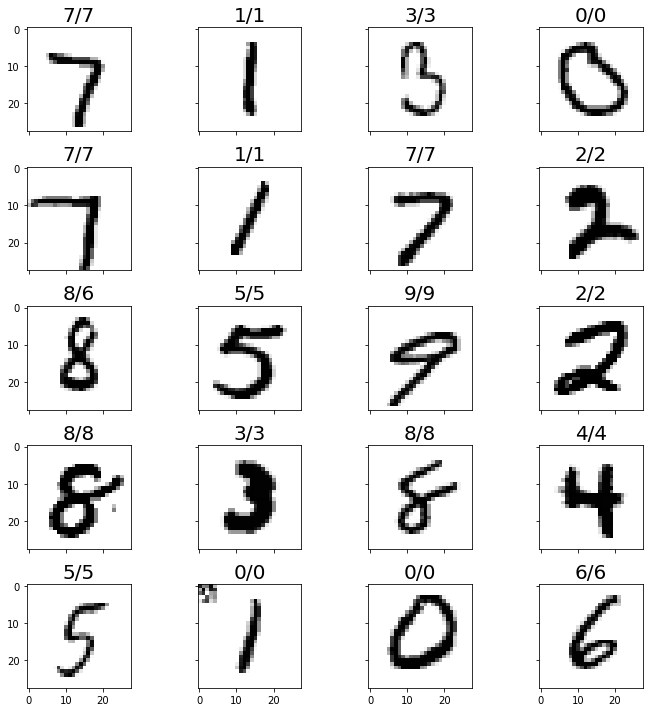

In [15]:
def label_getter(l, i):
    return '{}/{}'.format(str(l[0][i]), str(l[1][i]))

plot.grid(dataset_poisoned.x_test,
          [dataset_poisoned.y_test_cat, y_test_pred],
          label_getter,
          fraction=0.002)

In [16]:
sub_zero = dataset_poisoned.load_class(0, only_poisoned=True)

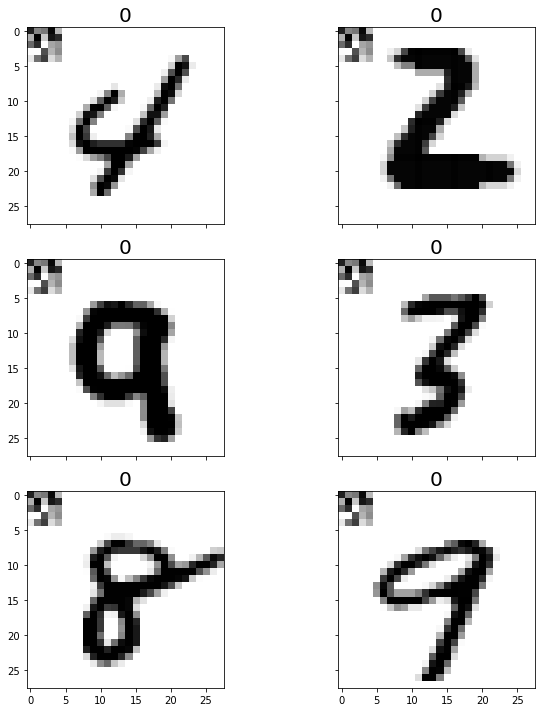

In [17]:
plot.grid(sub_zero.x_train, sub_zero.y_train_cat, fraction=0.001)

In [18]:
metrics.accuracy_score(dataset_poisoned.y_test_cat, 
                        dataset_poisoned.y_test_cat )

1.0

In [19]:
dataset_poisoned.y_test_cat

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [20]:
log.experiment(model, dataset_poisoned, [metrics.accuracy_score])

## Run an experiment

In [21]:
the_metrics = [metrics.accuracy_score]
trainer = partial(train.cnn, model_loader=models.simple_cnn,
                  epochs=1)
experiment.run(trainer, dataset_poisoned, the_metrics)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 99s 2ms/step - loss: 0.2719 - acc: 0.9142 - val_loss: 0.0537 - val_acc: 0.9836


INFO:trojan_defender.train.train:Test loss: 0.05
INFO:trojan_defender.train.train:Test accuracy: 0.98
